# Objective

This notebook shows how to do some preliminary processing on rasters. The following are shown:

1. Visualize data
2. Print metadata
3. Reproject raster from one coordinate system to another
4. Aggregate/upscale raster data
5. Save an array as a geotif file
6. Rescale raster data to match the resolution of a template raster
7. Realign the rescaled data in 5. above to make sure the raster grid aligns with that of a template raster

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from osgeo import gdal
import numpy.ma as ma
import geopandas as gpd
import rasterio as rio
import shapely
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

sns.set(font_scale=1.35, style='whitegrid')
%config Completer.use_jedi = False

In [2]:
ASO_file = 'ASO_50M_SWE_USCACE_20160401.tif'
PRISM_file = 'PRISM_PPT_20190108.tif'

# 1. Visualize data

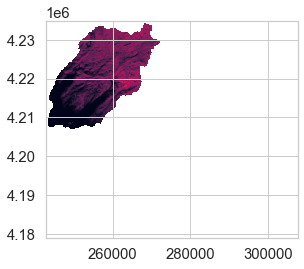

In [3]:
with rio.open(ASO_file) as src:
    show(src.read(1, masked=True), transform = src.transform)
    
### Another way to plot. Note that the axes are different!
# with rio.open(ASO_file) as src:
#     plt.imshow(src.read(1, masked=True))

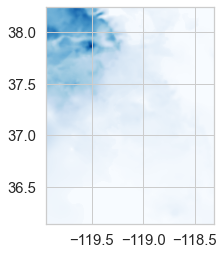

In [4]:
with rio.open(PRISM_file) as src:
    show(src.read(1, masked=True), transform = src.transform, cmap='Blues')

# 2. Print metadata

In [5]:
gdal.Info(PRISM_file).split('\n')

['Driver: GTiff/GeoTIFF',
 'Files: PRISM_PPT_20190108.tif',
 'Size is 196, 253',
 'Coordinate System is:',
 'GEOGCRS["NAD83",',
 '    DATUM["North American Datum 1983",',
 '        ELLIPSOID["GRS 1980",6378137,298.257222101,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    USAGE[',
 '        SCOPE["unknown"],',
 '        AREA["North America - NAD83"],',
 '        BBOX[14.92,167.65,86.46,-47.74]],',
 '    ID["EPSG",4269]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-119.945833333536513,38.245833333799503)',
 'Pixel Size = (0.008333333333000,-0.008333333333000)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 'Image 

# 3. Reprojection Function

Running gdal.Info() above on the sample ASO and PRISM file shows us that the PRISM data and ASO are in different coordinate systems. This is why the x-ticks and y-ticks for the two datasets were different when plotted above using rasterio.plot.show

Before we can compare the two datasets, we need to ensure that the coordinate systems are consistent. The PRISM data are in a geographic coordinate system, while the ASO data are in a projected coordinate system. A quick google search is the best way to understand the difference (e.g., https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs/)

Commonly used coordinate systems have an "EPSG" code associated with them (https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset). The EPSG code corresponding to the PRISM data is EPSG:4269.

In [6]:
def reproject_raster(src_file, dst_file, dst_crs = 'EPSG:4269'):
    """Reproject the src_file to a coordinate system specified by dst_crs.
    The result in stored in dst_file. EPSG:4269 corresponds to the coordinate
    system employed by PRISM.
    Source: https://rasterio.readthedocs.io/en/latest/topics/reproject.html"""


    with rio.open(src_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(dst_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
    return

### Example reprojection

In [7]:
ASO_file_reprojected = 'ASO_50M_SWE_USCACE_20160401_EPSG4269.tif'
desired_crs = 'epsg:4269'
reproject_raster(ASO_file, ASO_file_reprojected, desired_crs)

# 4. Aggregatation Functions

The ASO data are at 50-meter resolution. The PRISM data are originally at 800-meter resolution. I have downscaled the PRISM data to resolutions of 400-meter and 200-meter using an as-yet unpublished methodology. Downscaling to finer resolutions is not yet possible. To faciliate comparison between ASO and PRISM, the ASO data need to be upscaled from 50-meter to 200-meter, 400-meter and 800-meter.

The following functions help achieve this.

In [8]:
def aggregate2x2(src_array):
    """This function upscales src_array by a factor of 2. Specifically, it uses a 2x2 kernel
    (with a stride of 2) and average pools the src_array.
    """
    src_array = make_shape_even(src_array)
    agg_list = [[np.mean(src_array[row:row+2, col:col+2]) for col in np.arange(0,src_array.shape[1],2)] for row in np.arange(0,src_array.shape[0],2)]
    agg_array = np.array(agg_list).reshape(src_array.shape[0]//2,src_array.shape[1]//2)
    return np.asarray(agg_array, dtype=src_array.dtype)


def make_shape_even(src_array):
    """This function ensures that the shape of a masked array is divisible 2. 
    If not divisible by 2, this functions pads the borders with nan."""
    rows = src_array.shape[0]
    cols = src_array.shape[1]
    rows_dest = rows+1 if rows%2==1 else rows
    cols_dest = cols+1 if cols%2==1 else cols
    dst_array = np.empty((rows_dest,cols_dest))
    dst_array[:] = np.nan
    dst_array[:rows,:cols] = src_array.copy()
    return np.asarray(dst_array, dtype=src_array.dtype)

### Example aggregation

In [9]:
eg_array = np.arange(16).reshape(4,4)
agg_egarray = aggregate2x2(eg_array.astype('float32'))
print (eg_array)
print (agg_egarray)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[ 2.5  4.5]
 [10.5 12.5]]


### Example aggregation of an ASO file
Each ASO file (or dataset) is a masked array. Hence, the "masked=True" argument. The masked values are -9999. I am converting them to nan so that they don't corrupt the mean-aggregation.

In [10]:
src_raster = rio.open(ASO_file_reprojected)
src_array = src_raster.read(1, masked=True).filled(fill_value=np.nan)
agg_array = aggregate2x2(src_array)
src_raster.close()

Note the white space in the plot. This is because the ASO dataset is a masked array.

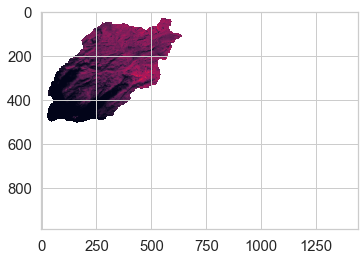

In [11]:
plt.imshow(src_array)

# 5. Function to save aggregated array

After aggregating, copy the meta information from the source file, and update the transform.

In [12]:
def write_agg_geotif(template, agg_array, dst_filename):
    """Write the aggregated dataset. This assumes that the
    aggregated dataset upscales src by a factor of 2. For other
    factors, replace '2' by the actual factor."""

    transform = template.transform * template.transform.scale(2,2)
    width = int(np.ceil(template.width/2))
    height = int(np.ceil(template.height/2))
    kwargs = template.meta.copy()
    kwargs.update({
        'transform': transform,
        'width': width,
        'height': height
    })


    with rio.open(dst_filename, "w", **kwargs) as dest:
        dest.write(agg_array,1)
        dest.nodata = template.read(1, masked=True).fill_value
    
    return

### Example: Aggregate from 50M to 100M

In [13]:
src_raster = rio.open(ASO_file_reprojected)
agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
dst_filename = 'ASO_100M_SWE_USCACE_20160401_EPSG4269.tif'
write_agg_geotif(src_raster, agg_array, dst_filename)
src_raster.close()

### Example: Aggregate from 100M to 200M

In [14]:
src_raster = rio.open('ASO_100M_SWE_USCACE_20160401_EPSG4269.tif')
agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
dst_filename = 'ASO_200M_SWE_USCACE_20160401_EPSG4269.tif'
write_agg_geotif(src_raster, agg_array, dst_filename)
src_raster.close()

### Example: Aggregate from 200M to 400M

In [15]:
src_raster = rio.open('ASO_200M_SWE_USCACE_20160401_EPSG4269.tif')
agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
dst_filename = 'ASO_400M_SWE_USCACE_20160401_EPSG4269.tif'
write_agg_geotif(src_raster, agg_array, dst_filename)
src_raster.close()

### Example: Aggregate from 400M to 800M

In [16]:
src_raster = rio.open('ASO_400M_SWE_USCACE_20160401_EPSG4269.tif')
agg_array = aggregate2x2(src_raster.read(1, masked=True).filled(fill_value=np.nan))
dst_filename = 'ASO_800M_SWE_USCACE_20160401_EPSG4269.tif'
write_agg_geotif(src_raster, agg_array, dst_filename)
src_raster.close()

# 6. Rescale PRISM and ASO grids

Even when ASO and PRISM datasets have the same resolution (e.g., 800M), the pixel sizes are not exactly the same. A usage of gdal.Info() reveals that the ASO 800M dataset has a pixel size of 0.0084 degrees, while the PRISM 800M dataset has a pixel size of 0.0083 degrees. For comparing the two datasets, it is desirable to ensure that the two sets of pixels are exactly the same

In [17]:
def rescale_src_from_template(template_file, src_file, dst_file):
    """This function rescales the src_file raster to the resolution of the template_file raster.
    The rescaled src_file is stored in dst_file raster."""
    template = rio.open(template_file)
    src = rio.open(src_file)

    scale_factor = template.res[0]/src.res[0]

    src_transform = src.transform

    dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor)
    height = int(src.meta['height']/scale_factor)
    width = int(src.meta['width']/scale_factor)

    data = src.read()

    kwargs = src.meta.copy()
    kwargs['transform'] = dst_transform
    kwargs['height'] = height
    kwargs['width'] = width
    kwargs['crs'] = template.crs
    src.close()


    with rio.open(dst_file, 'w', **kwargs) as dst:

        for i, band in enumerate(data, 1):
            dest = np.zeros((height, width), dtype=band.dtype)

            reproject(
                band,
                dest,
                src_transform=src_transform,
                src_crs=template.crs,
                src_nodata=-9999,
                dst_transform=dst_transform,
                dst_crs=template.crs,
                resampling=Resampling.bilinear)

            dst.write(dest, indexes=i)
    return

### Example
Let's rescale the PRISM_file to the exact resolution of 'ASO_800M_SWE_USCACE_20160401_EPSG4269.tif'.

In [19]:
rescaled_PRISM_file = 'PRISM_PPT_20190108_rescaled.tif'
template_file = 'ASO_800M_SWE_USCACE_20160401_EPSG4269.tif'
rescale_src_from_template(template_file, PRISM_file, rescaled_PRISM_file)

# 7. Align PRISM and ASO grids
 
A careful visual inspection reveals that although the PRISM and ASO pixel sizes are now identical, the grids are still not aligned. E.g., see plot below

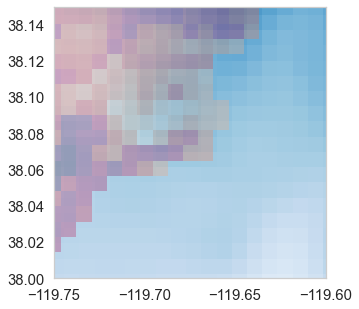

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

with rio.open('PRISM_PPT_20190108_rescaled.tif') as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap='Blues', vmin=4, vmax=10)

with rio.open('ASO_800M_SWE_USCACE_20160401_EPSG4269.tif') as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.3)
    
plt.xlim(right=-119.6, left=-119.75)
plt.ylim(bottom=38, top=38.15)

plt.grid(False)

In [21]:
def get_Points_gdf(src_file):
    """This function reads in a raster, and obtains Long/Lat values of the center
    of each pixel. It returns a geodataframe."""
    raster = rio.open(src_file)
    arr = raster.read(1)
    indices = np.argwhere(~np.isnan(arr))

    coords = raster.xy(indices[:,0], indices[:,1])

    Points_gdf= gpd.GeoDataFrame({'Longitude':coords[0],'Latitude': coords[1]},
                                  geometry=[shapely.geometry.Point(x, y) for x, y in zip(coords[0], coords[1])])
    return Points_gdf



def translate_rescaled_src(template_file, src_file, rescaled_src_file, Points_gdf, dst_file):
    """This function rescales and translates the src_file raster so that the grid is perfectly
    aligned with the template_file raster grid. It uses the rescaled_src_file to determine how much 
    translation is needed."""
    
    template = rio.open(template_file)
    rescaled_src = rio.open(rescaled_src_file)

    rc = rio.transform.rowcol(rescaled_src.transform, Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    cr_coord = [item + 0.5 for item in reversed(rc)]

    pixel_coord = ~rescaled_src.transform*(Points_gdf.Longitude[0], Points_gdf.Latitude[0])
    pixel_coord = list(pixel_coord)

    offset_x = pixel_coord[0] - cr_coord[0]
    offset_y = pixel_coord[1] - cr_coord[1]



    with rio.open(src_file) as src:
        
        scale_factor = template.res[0]/src.res[0]
        
        src_transform = src.transform

        dst_transform = src.transform * src.transform.scale(scale_factor,scale_factor) * src.transform.translation(offset_x,offset_y)

        height = int(src.meta['height']/scale_factor)
        width = int(src.meta['width']/scale_factor)

        data = src.read()

        kwargs = src.meta.copy()
        kwargs['transform'] = dst_transform
        kwargs['height'] = height
        kwargs['width'] = width
        kwargs['crs'] = template.crs



        with rio.open(dst_file, 'w', **kwargs) as dst:

            for i, band in enumerate(data, 1):
                dest = np.zeros((height, width), dtype=band.dtype)

                reproject(
                    band,
                    dest,
                    src_transform=src_transform,
                    src_crs=template.crs,
                    src_nodata=-9999,
                    dst_transform=dst_transform,
                    dst_crs=template.crs,
                    resampling=Resampling.bilinear)

                dst.write(dest, indexes=i)
        
    return

### Example run

In [22]:
Points_gdf = get_Points_gdf(template_file)

rescale_translated_PRISM_file = 'PRISM_PPT_20190108_rescaled_translated.tif'
translate_rescaled_src(template_file, PRISM_file, rescaled_PRISM_file, Points_gdf, rescale_translated_PRISM_file)

### Confirm that the grids are aligned

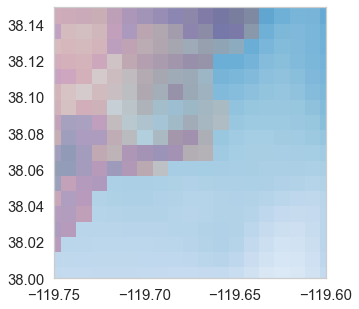

In [23]:
fig, ax = plt.subplots(figsize=(5,5))

with rio.open('PRISM_PPT_20190108_rescaled_translated.tif') as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, cmap='Blues', vmin=4, vmax=10)

with rio.open('ASO_800M_SWE_USCACE_20160401_EPSG4269.tif') as src:
    show(src.read(1, masked=True), ax=ax, transform=src.transform, alpha=0.3)
    
plt.xlim(right=-119.6, left=-119.75)
plt.ylim(bottom=38, top=38.15)

plt.grid(False)